# Geometric Datasets: Exeter

## Imports

### Basic

In [46]:
import wntr
import pandas as pd
import numpy as np
import pickle
import networkx as nx

#Custom .py file
from PrasadParkIndex import *
from res_index import *

### PyTorch and PyG

In [8]:
import torch
from torch_geometric.data import Data

from torch_geometric.datasets import TUDataset

C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### DeepSNAP

In [9]:
from deepsnap.graph import Graph as dSNAP_Graph
from deepsnap.dataset import GraphDataset as dSNAP_GraphDS

## Original inp file

In [10]:
# Create a water network model
def load_inp(inp_file_path):
    wn_WDS = wntr.network.WaterNetworkModel(inp_file_path)

    # Plot the network
    wntr.graphics.plot_network(wn_WDS, title=wn_WDS.name)

    # Simulate hydraulics
    sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
    results_WDS = sim_WDS.run_sim()
    
    return(wn_WDS, sim_WDS, results_WDS)

In [11]:
name_WDS = 'TLN'

In [12]:
WDS_info = pd.read_csv('./networks/Exeter/TLN_info.csv', dtype = {'NodeID': str} )

In [13]:
WDS_info.columns

Index(['D', 'Cost', 'NodeID', 'MinPressure_m', 'UNITS_TO_M'], dtype='object')

In [18]:
min_pres = WDS_info[['NodeID', 'MinPressure_m']].dropna()
min_pres = min_pres.set_index('NodeID')
print(min_pres)

        MinPressure_m
NodeID               
2                30.0
3                30.0
4                30.0
5                30.0
6                30.0
7                30.0


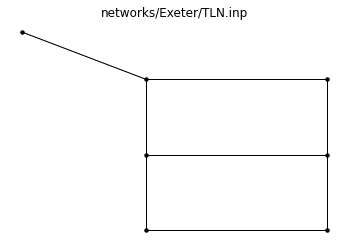

In [23]:
path= 'networks/Exeter/'+name_WDS+'.inp'
wn_WDS, b, c = load_inp(path)

In [24]:
UNIT_TO_M = 0.0254 
PMIN_WDS = 28.1236 #m #Equivalent to 40 psi #REFERENCE

In [129]:
num_pipes = wn_WDS.num_pipes

avail_diams = list(WDS_info.D.dropna()) #[6, 8, 10, 12, 14] #inches
pipe_names = wn_WDS.link_name_list

seed = 958 #Trial seed: 4345
np.random.seed(seed)

N_iter = 100

In [130]:
avail_diams

[1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

## Dataset Creation

In [115]:
node_attributes = ['node_id','node_type','base_demand','elevation','base_head','coords']
edge_attributes = ['link_id','length','diameter','roughness']

def from_wntr_to_pandas(wn):
  # node features and coordinates
  df_nodes = pd.DataFrame(columns=node_attributes)
  for i, node_id in enumerate(wn.nodes):    
    this_node = wn.get_node(node_id)
    if this_node.node_type == 'Junction':
      df_nodes.loc[i,:] = (node_id, 0, this_node.base_demand, this_node.elevation, 0, this_node.coordinates)      
    elif this_node.node_type == 'Reservoir':
      df_nodes.loc[i,:] = (node_id, 1, 0, 0, this_node.base_head, this_node.coordinates)      
    else:
      print('Only Junctions and Reservoirs so far')      
      break
      
  # link features
  df_links = pd.DataFrame(columns=edge_attributes)
  for i, link_id in enumerate(wn.links):    
    this_link = wn.get_link(link_id)
    if this_link.link_type == 'Pipe':
      df_links.loc[i,:] = (link_id, this_link.length, this_link.diameter, this_link.roughness)      
    else:
      print('Only Pipes so far')      
      break

  # edge indexes
  G = wn.get_graph()
  #COO_edges =0  
  COO_edges = np.array(nx.to_scipy_sparse_matrix(G,format='coo').nonzero())

  return df_nodes, df_links, COO_edges

def from_wntr_to_geometric(wn):      
  df_nodes, df_links, COO_edges = from_wntr_to_pandas(wn)   # get pandas dataframes
  
  # create torch data 
  x = torch.tensor(df_nodes[['node_type','base_demand','elevation','base_head']].astype(float).values, dtype=torch.float)
  pos = torch.tensor(df_nodes['coords'], dtype=torch.float)
  edge_index = torch.tensor(COO_edges, dtype=torch.long)
  edge_attr = torch.tensor(df_links[['length','diameter','roughness']].astype(float).values, dtype=torch.float)
  data = Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)

  return data, df_nodes, df_links

In [116]:
data, df_nodes, df_links = from_wntr_to_geometric(wn_WDS)

In [117]:
from res_index import *

In [118]:
results_WDS.node['pressure']

name,2,3,4,5,6,7,1
0,57.458965,44.703655,21.784094,25.700605,-802.459229,10.844771,4.394531e-07


In [119]:
print(res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini'))

0   -2.16297
dtype: float64


In [120]:
first_DB = []
fail_DB = []

all_geom_data = [] # geometric data

for sim in range(N_iter):
  DB_row = []  # y data
  # echo on screen
  if sim % 5 == 0:
    print(f'iter: {sim}')
    #print(flowrate)
  
  # assign diameters    
  new_diams = np.random.choice(avail_diams, num_pipes)
  new_diams = new_diams * UNIT_TO_M
  for i in range(num_pipes):
      c_pipe = wn_WDS.get_link(pipe_names[i])
      c_pipe.diameter = new_diams[i]
  
  # run the simulation
  try:
    # Simulate hydraulics
    sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
    results_WDS = sim_WDS.run_sim()
    
    try:
      flowrate = pd.DataFrame(results_AnyT.link['flowrate']['82']) #FLowrate at the link with the pump
    except Exception as e1:
      flowrate = 0
    
    # get resilience indexes  
    RI_PP = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
    RI_Todini = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')
    
    #RI_PP = PP_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)
    #RI_Todini = wntr.metrics.hydraulic.todini_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)
    
    DB_row.append(RI_PP)
    DB_row.append(RI_Todini)
    
    first_DB.append(DB_row)
    
    # create Geometric Data (no y yet)
    data, _, _ = from_wntr_to_geometric(wn_WDS)
    all_geom_data.append(data)
      
  except Exception as e:
    fail_row = [sim]
    fail_row.append(np.round(new_diams/UNIT_TO_M, 0))
    fail_row.append(wn_WDS)
    fail_row.append(e)
    print(e)
    fail_DB.append(fail_row)
    #wn_WDS.write_inpfile('Failed files/' + 'fail_' + heading+'_'+str(sim)+ '.inp', version=2.2)

iter: 0
iter: 5


C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


iter: 10
iter: 15
iter: 20
iter: 25
iter: 30
iter: 35
iter: 40
iter: 45
iter: 50
iter: 55
iter: 60
iter: 65
iter: 70
iter: 75
iter: 80
iter: 85
iter: 90
iter: 95


In [128]:
first_DB

[[0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,
  0    0.903806
  dtype: float64],
 [0    0.903806
  dtype: float64,


In [110]:
for name, node in wn_WDS.nodes(wntr.network.Junction):
    print(name)

2
3
4
5
6
7


In [72]:
len(all_geom_data)

100

In [73]:
all_geom_data[0]

Data(edge_attr=[8, 3], edge_index=[2, 8], pos=[7, 2], x=[7, 4])

In [74]:
all_geom_data[0].edge_attr[0:10]

tensor([[1.0000e+03, 3.0480e-01, 1.3000e+02],
        [1.0000e+03, 3.0480e-01, 1.3000e+02],
        [1.0000e+03, 2.5400e-01, 1.3000e+02],
        [1.0000e+03, 1.5240e-01, 1.3000e+02],
        [1.0000e+03, 3.0480e-01, 1.3000e+02],
        [1.0000e+03, 1.5240e-01, 1.3000e+02],
        [1.0000e+03, 2.0320e-01, 1.3000e+02],
        [1.0000e+03, 3.0480e-01, 1.3000e+02]])

In [2]:

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

NameError: name 'TUDataset' is not defined

In [1]:
dataset[0].y

NameError: name 'dataset' is not defined

In [4]:
dataset[1]

Data(edge_index=[2, 102], x=[23, 3], y=[1])

In [5]:
dataset[2]

Data(edge_index=[2, 92], x=[25, 3], y=[1])

In [6]:
len(dataset)

600

In [7]:
type(dataset)

torch_geometric.datasets.tu_dataset.TUDataset

In [10]:
dataset

ENZYMES(600)

In [11]:
from deepsnap.graph import Graph
from torch_geometric.datasets import Planetoid

In [12]:
pyg_dataset = Planetoid('./cora', 'Cora')
graph = Graph.pyg_to_graph(pyg_dataset[0])

Processing...
Done!


In [13]:
graph

Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])

In [15]:
graph1 = Graph.pyg_to_graph(dataset[0])

In [16]:
graph1

Graph(G=[], edge_index=[2, 168], edge_label_index=[2, 168], graph_label=[1], node_feature=[37, 3], node_label_index=[37])